In [127]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,BatchNormalization
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
df = pd.read_csv('AAPL.csv')

In [4]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


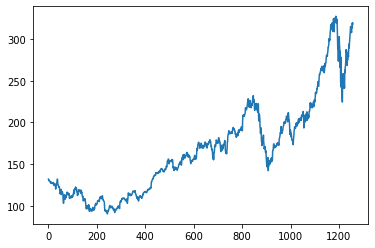

In [45]:
# use stock close price data for model
df1 = df.reset_index()['close']
plt.plot(df1)

Data Preprocessing

In [46]:
# scale data
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(df1.shape[0],-1))

In [56]:
# split into in sample and out of sample
training_size = int(len(df1)*0.8)
test_size = len(df1) - training_size
train_data, test_data = df1[:training_size,:], df1[training_size:len(df1),:]

In [167]:
train_data.shape

(1006, 1)

In [102]:
# create dataset
# e.g. [100,200,300,400] -> [200,300,400,...] 
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [103]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [438]:
x_train.shape, y_train.shape

((906, 100, 1), (906,))

In [126]:
# reshape input to be [samples, time steps, features] which is required for LSTM
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1] , -1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , -1)

Model

In [129]:
model=Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1:])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 128)          66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 100, 128)          512       
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 100, 128)          512       
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)              

In [133]:
optimizer = Adam(lr=0.001)
model.compile(loss = 'mean_squared_error' , optimizer = optimizer, metrics = ['mse'])

In [134]:
batch_size = 64
epochs = 70

In [135]:
# start training
history = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    batch_size = batch_size,
    epochs = epochs
)

Train on 906 samples, validate on 152 samples
Epoch 1/70
906/906 [==============================] - 39s 43ms/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.1702 - val_mse: 0.1702
Epoch 2/70
906/906 [==============================] - 27s 29ms/sample - loss: 0.0053 - mse: 0.0053 - val_loss: 0.1839 - val_mse: 0.1839
Epoch 3/70
906/906 [==============================] - 27s 30ms/sample - loss: 0.0037 - mse: 0.0037 - val_loss: 0.1985 - val_mse: 0.1985
Epoch 4/70
906/906 [==============================] - 28s 31ms/sample - loss: 0.0032 - mse: 0.0032 - val_loss: 0.1787 - val_mse: 0.1787
Epoch 5/70
906/906 [==============================] - 29s 32ms/sample - loss: 0.0031 - mse: 0.0031 - val_loss: 0.1892 - val_mse: 0.1892
Epoch 6/70
906/906 [==============================] - 30s 33ms/sample - loss: 0.0027 - mse: 0.0027 - val_loss: 0.1825 - val_mse: 0.1825
Epoch 7/70
906/906 [==============================] - 29s 32ms/sample - loss: 0.0025 - mse: 0.0025 - val_loss: 0.1817 - val_mse: 0.1817
Ep

In [439]:
model.save('stock.h5')

In [141]:
test_predict = model.predict(x_test)
train_predict = model.predict(x_train)

In [144]:
test_predict = scaler.inverse_transform(test_predict)
train_predict = scaler.inverse_transform(train_predict)

In [437]:
import math
from sklearn.metrics import mean_squared_error
print('test MSE:{}, train MSE:{}'.format(math.sqrt(mean_squared_error(y_test,test_predict)),
      math.sqrt(mean_squared_error(y_train,train_predict))))

test MSE:232.44135002562012, train MSE:157.57386412741076


Visualize model performance

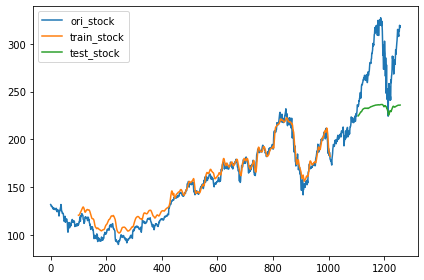

In [232]:
time_step=100
train_size = train_predict.shape[0]
test_size = test_predict.shape[0]
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:train_size+time_step, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[train_size+(look_back*2):df1.shape[0], :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1), label = 'ori_stock', linestyle = 'solid')
plt.plot(trainPredictPlot, label = 'train_stock', linestyle = 'solid')
plt.plot(testPredictPlot, label = 'test_stock', linestyle = 'solid')
plt.legend()
plt.tight_layout()
plt.show()

Forecast the future stock price

In [397]:
# get the last time_step(100) base data
forecast_data_base = test_data.flatten()[len(test_data)-time_step:]
forecast_data = list(forecast_data_base)

In [398]:
predicted_stock = []
n_steps = 100
i=0
# start prediction
while(i<30):
    if(len(forecast_data)>100):
        # get latest 100 data
        temp_forecast_data = forecast_data[i:]
        # reshape to the required shape for model prediction
        temp_forecast_data = temp_forecast_data.reshape((1, n_steps, -1))
        output = model.predict(temp_forecast_data, verbose=0)[0][0]
        # store into predicted and forecast_data
        predicted_stock.append(output)
        forecast_data = np.append(forecast_data,output)
        i = i + 1
    else:
        # for base data prediction case
        forecast_data_base = forecast_data_base.reshape((1, n_steps, 1))
        output = model.predict(forecast_data_base, verbose=0)[0][0]
        predicted_stock.append(output)
        forecast_data = np.array(forecast_data)
        forecast_data = np.append(forecast_data,output)
        i = i + 1
    

In [414]:
predicted_output_reshape = np.array(predicted_stock)
# reshape output for the scaler inverse
plot_stock = predicted_output_reshape.reshape(predicted_output_reshape.shape[0],-1)
plot_stock = scaler.inverse_transform(plot_stock)
# base data inverse
plot_df = scaler.inverse_transform(df1)

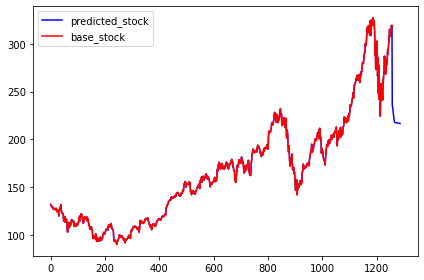

In [434]:
# plot the merge array of prediction and base stock
plt.plot(np.append(plot_df,plot_stock), linestyle = 'solid', label = 'predicted_stock', color = 'b')
plt.plot(plot_df, linestyle = 'solid', label = 'base_stock', color = 'r')
plt.legend()
plt.tight_layout()